# Import stuff

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import shap
shap.initjs()

# Load data, clean, feature engineering...

In [2]:
df = pd.read_csv('../data/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df['Embarked'].fillna('S', inplace = True)
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first = True)
df = pd.concat([df, df_embarked], axis=1).drop(['Embarked'], axis=1)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Split & train

In [4]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [5]:
xgb = XGBClassifier(max_depth=5, n_estimators = 30, learning_rate=0.1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

![](img/explain.jpg)

### Explain to me!

In [6]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

In [7]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Age (2) and Sex (1, female) has a big positive impact, while Pclass (3) a negative one.

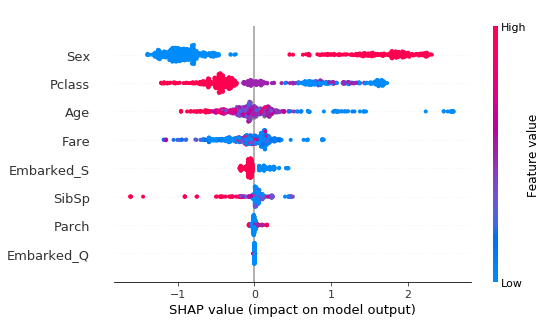

In [8]:
shap.summary_plot(shap_values, X_train, show = False)

* The gender has the maximum impact.
* Pclass is interesting, first class gives you a big range of impact (ie: grants not that much), while being 3th class means you are in big trouble
* A high SibSp number can be very significant.
* The effect is largely linear, as expected from logistic regression but SHAP shows some non-linearity arising from feature interactions.
* Where you embarked the Titanic doesn't matter honestly, after all, the boat is a boat.

In [9]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

1. Second class, female
2. First class, female
3. Second class, female
4. MEN
5. Men, first class
6. Female children


In [10]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

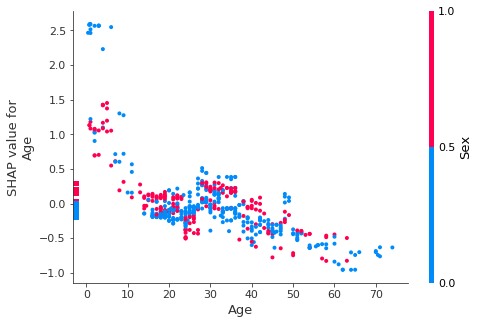

In [11]:
shap.dependence_plot("Age", shap_values, X_train, show = False)

1. A significant positive impact can be seen for Age < 10.
2. After 12 ¿? you are no longer a "children" ...
3. Impact improves a bit around 29 and 49

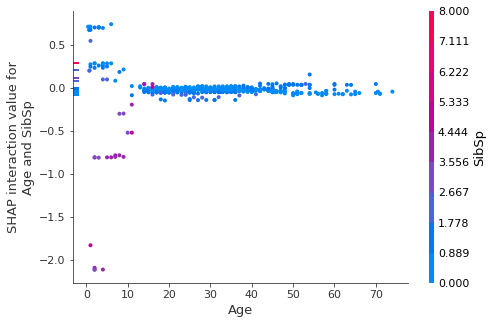

In [12]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.dependence_plot(("Age", "SibSp"),shap_interaction_values, X_train,display_features=X_train)

The bigger the family, the worse are your chances... if you are young, that is.